# Santander Customer Transaction Prediction

In this challenge, we invite Kagglers to help us identify which customers will make a specific transaction in the future, irrespective of the amount of money transacted. The data provided for this competition has the same structure as the real data we have available to solve this problem.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

Let's start by importing the training and test csv files

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import QuantileTransformer
from catboost import CatBoostClassifier, Pool

In [45]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [39]:
clf = CatBoostClassifier(iterations=300, eval_metric='AUC', verbose=False)
cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=5)

Learning rate set to 0.205956
0:	total: 108ms	remaining: 32.4s
1:	total: 200ms	remaining: 29.8s
2:	total: 285ms	remaining: 28.2s
3:	total: 369ms	remaining: 27.3s
4:	total: 447ms	remaining: 26.4s
5:	total: 523ms	remaining: 25.6s
6:	total: 611ms	remaining: 25.6s
7:	total: 685ms	remaining: 25s
8:	total: 762ms	remaining: 24.7s
9:	total: 839ms	remaining: 24.3s
10:	total: 919ms	remaining: 24.1s
11:	total: 999ms	remaining: 24s
12:	total: 1.08s	remaining: 23.8s
13:	total: 1.15s	remaining: 23.5s
14:	total: 1.23s	remaining: 23.3s
15:	total: 1.31s	remaining: 23.2s
16:	total: 1.38s	remaining: 23s
17:	total: 1.46s	remaining: 22.9s
18:	total: 1.54s	remaining: 22.8s
19:	total: 1.62s	remaining: 22.7s
20:	total: 1.7s	remaining: 22.6s
21:	total: 1.78s	remaining: 22.5s
22:	total: 1.85s	remaining: 22.3s
23:	total: 1.93s	remaining: 22.2s
24:	total: 2.01s	remaining: 22.1s
25:	total: 2.08s	remaining: 22s
26:	total: 2.17s	remaining: 21.9s
27:	total: 2.24s	remaining: 21.8s
28:	total: 2.32s	remaining: 21.7s
29:

array([0.88963414, 0.88778053, 0.89321397, 0.89152525, 0.89509884])

Learning rate set to 0.219382
0:	total: 107ms	remaining: 31.9s
1:	total: 252ms	remaining: 37.6s
2:	total: 380ms	remaining: 37.6s
3:	total: 480ms	remaining: 35.5s
4:	total: 557ms	remaining: 32.8s
5:	total: 652ms	remaining: 31.9s
6:	total: 734ms	remaining: 30.7s
7:	total: 823ms	remaining: 30.1s
8:	total: 931ms	remaining: 30.1s
9:	total: 1.05s	remaining: 30.4s
10:	total: 1.18s	remaining: 31.1s
11:	total: 1.3s	remaining: 31.1s
12:	total: 1.39s	remaining: 30.6s
13:	total: 1.48s	remaining: 30.3s
14:	total: 1.56s	remaining: 29.7s
15:	total: 1.65s	remaining: 29.2s
16:	total: 1.74s	remaining: 29s
17:	total: 1.84s	remaining: 28.8s
18:	total: 1.98s	remaining: 29.2s
19:	total: 2.1s	remaining: 29.4s
20:	total: 2.23s	remaining: 29.6s
21:	total: 2.37s	remaining: 30s
22:	total: 2.5s	remaining: 30.1s
23:	total: 2.59s	remaining: 29.7s
24:	total: 2.67s	remaining: 29.3s
25:	total: 2.77s	remaining: 29.2s
26:	total: 2.86s	remaining: 28.9s
27:	total: 2.94s	remaining: 28.6s
28:	total: 3.05s	remaining: 28.5s
2

0.9230505033567779

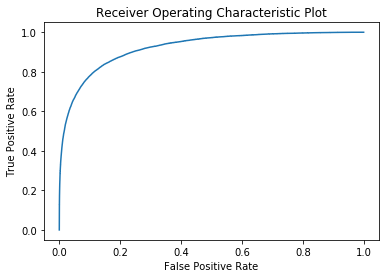

In [41]:
clf.fit(X_train, y_train)
fpr, tpr, thr = roc_curve(y_train, clf.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

In [4]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [5]:
test_df.head()

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,test_0,11.0656,7.7798,12.9536,9.4292,11.4327,-2.3805,5.8493,18.2675,2.1337,...,-2.1556,11.8495,-1.4300,2.4508,13.7112,2.4669,4.3654,10.7200,15.4722,-8.7197
1,test_1,8.5304,1.2543,11.3047,5.1858,9.1974,-4.0117,6.0196,18.6316,-4.4131,...,10.6165,8.8349,0.9403,10.1282,15.5765,0.4773,-1.4852,9.8714,19.1293,-20.9760
2,test_2,5.4827,-10.3581,10.1407,7.0479,10.2628,9.8052,4.8950,20.2537,1.5233,...,-0.7484,10.9935,1.9803,2.1800,12.9813,2.1281,-7.1086,7.0618,19.8956,-23.1794
3,test_3,8.5374,-1.3222,12.0220,6.5749,8.8458,3.1744,4.9397,20.5660,3.3755,...,9.5702,9.0766,1.6580,3.5813,15.1874,3.1656,3.9567,9.2295,13.0168,-4.2108
4,test_4,11.7058,-0.1327,14.1295,7.7506,9.1035,-8.5848,6.8595,10.6048,2.9890,...,4.2259,9.1723,1.2835,3.3778,19.5542,-0.2860,-5.1612,7.2882,13.9260,-9.1846


In [6]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [7]:
test_df.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,10.658737,-1.624244,10.707452,6.788214,11.076399,-5.050558,5.415164,16.529143,0.277135,7.569407,...,3.189766,7.458269,1.925944,3.322016,17.996967,-0.133657,2.290899,8.912428,15.869184,-3.246342
std,3.036716,4.040509,2.633888,2.052724,1.616456,7.869293,0.864686,3.424482,3.333375,1.231865,...,4.551239,3.025189,1.479966,3.995599,3.140652,1.429678,5.446346,0.920904,3.008717,10.398589
min,0.188700,-15.043400,2.355200,-0.022400,5.484400,-27.767000,2.216400,5.713700,-9.956000,4.243300,...,-14.093300,-2.407000,-3.340900,-11.413100,9.382800,-4.911900,-13.944200,6.169600,6.584000,-39.457800
25%,8.442975,-4.700125,8.735600,5.230500,9.891075,-11.201400,4.772600,13.933900,-2.303900,6.623800,...,-0.095000,5.166500,0.882975,0.587600,15.634775,-1.160700,-1.948600,8.260075,13.847275,-11.124000
50%,10.513800,-1.590500,10.560700,6.822350,11.099750,-4.834100,5.391600,16.422700,0.372000,7.632000,...,3.162400,7.379000,1.892600,3.428500,17.977600,-0.162000,2.403600,8.892800,15.943400,-2.725950
75%,12.739600,1.343400,12.495025,8.327600,12.253400,0.942575,6.005800,19.094550,2.930025,8.584825,...,6.336475,9.531100,2.956000,6.174200,20.391725,0.837900,6.519800,9.595900,18.045200,4.935400
max,22.323400,9.385100,18.714100,13.142000,16.037100,17.253700,8.302500,28.292800,9.665500,11.003600,...,20.359000,16.716500,8.005000,17.632600,27.947800,4.545400,15.920700,12.275800,26.538400,27.907400


In [8]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [9]:
missing_data(train_df)

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,int64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [10]:
missing_data(test_df)

,ID_code,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
Total,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Percent,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Types,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


## Distribution of the target variable

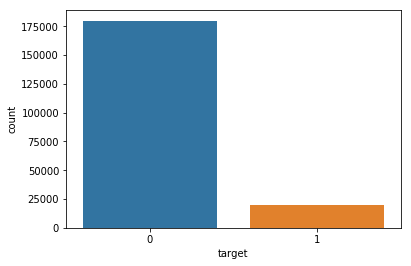

In [11]:
sns.countplot(train_df['target'])

In [12]:
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0]))

There are 10.049% target values with 1


In [34]:
X_train = train_df.drop(['ID_code', 'target'], axis=1).values
y_train = train_df['target'].values

In [5]:
test_X = test_df.drop(['ID_code'], axis=1).values

In [100]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
test_X = scaler.transform(test_X)

In [44]:
rfc_clf = RandomForestClassifier(n_estimators = 100)
rfc_clf.fit(X_train, y_train)
fpr, tpr, thr = roc_curve(y_train, rfc_clf.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

[[44423   520]
 [ 4131   926]]
0.90698
0.5857711530731975


# XGBoost without quantile transformer

0.8571430876079225

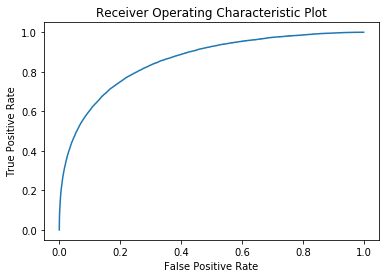

In [7]:
xgb_clf = XGBClassifier()
xgb_clf.fit(X_train, y_train)
fpr, tpr, thr = roc_curve(y_train, xgb_clf.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

In [8]:
cross_val_score(xgb_clf, X_train, y_train, scoring='roc_auc', cv=10).mean()

0.8317198150911891

# XGBoost with quantile transformer

0.8571430876079225

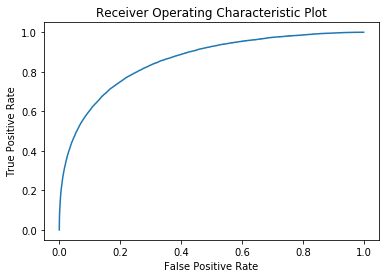

In [9]:
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), XGBClassifier())
pipeline.fit(X_train, y_train)
fpr, tpr, thr = roc_curve(y_train, pipeline.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

In [10]:
cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10).mean()

0.8317227796694919

# GaussianNB without quantile transformer

0.8899667114457852

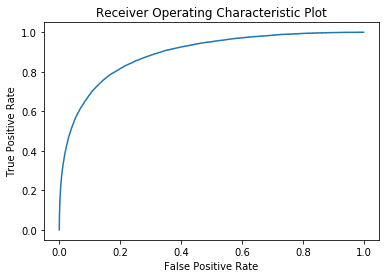

In [127]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)
fpr, tpr, thr = roc_curve(y_train, nb_clf.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

In [128]:
cross_val_score(nb_clf, X_train, y_train, scoring='roc_auc', cv=10).mean()

0.8884580262215318

# GaussianNB with quantile transformer

0.8911292421910241

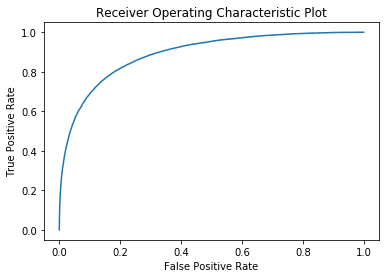

In [4]:
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X_train, y_train)
fpr, tpr, thr = roc_curve(y_train, pipeline.predict_proba(X_train)[:,1])
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
auc(fpr, tpr)

In [5]:
cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10).mean()

0.8894294277934138

In [42]:
X_test = test_df.iloc[:, 1:].values.astype('float64')
submission = pd.read_csv('sample_submission.csv')
submission['target'] = clf.predict_proba(X_test)[:,1]
submission.to_csv('submission_cat.csv', index=False)

In [43]:
submission.head()

,ID_code,target
0,test_0,0.091181
1,test_1,0.223450
2,test_2,0.316658
3,test_3,0.138779
4,test_4,0.048507


In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train_df = train.copy()
test_df = test.copy()
train_df.drop(columns=["ID_code", "target"], inplace=True)
test_df.drop(columns=["ID_code"], inplace=True)
target = train.target

In [50]:
 def augment_train(df_train, y_train):   
    t0 = df_train[y_train == 0].copy()
    t1 = df_train[y_train == 1].copy()
    i = 0
    N = 3
    for I in range(2):  # augment data into 2x
        for col in df_train.columns:
            i = i + 1000
            np.random.seed(i)
            np.random.shuffle(t0[col].values)
            np.random.shuffle(t1[col].values)
        df_train = pd.concat([df_train, t0.copy()])
        df_train = pd.concat([df_train, t1.copy()])
        y_train = pd.concat([y_train, pd.Series([0] * t0.shape[0]), pd.Series([1] * t1.shape[0])])
    return df_train, y_train

In [56]:
model = CatBoostClassifier(subsample=0.36, #rawdata 0.5  ×2 0.45 ×3 0.36
                            custom_loss='Logloss',
                           random_strength = 0,
                           max_depth=3,
                           eval_metric="AUC",
                           learning_rate=0.02,
                           iterations=60000,
                           #class_weights=[1,2],
                           bootstrap_type='Bernoulli',
                           #rsm=0.045,
                            l2_leaf_reg=0.3,
                           random_seed=432013,
                           od_type="Iter",
                           border_count=128
                           #has_time= True 
                          )

In [52]:
def run_cat(model,  trt, tst, tar,n_splits=5, plot=False):   
    kf = KFold(n_splits=n_splits, random_state=432013, shuffle=True)
    oof = np.zeros(len(trt))
    feature_importance_df = pd.DataFrame()
    y_valid_pred = 0 * tar
    y_test_pred = 0
    for n_fold, (train_index, valid_index) in enumerate(kf.split(trt, tar)):
        y_train, y_valid = tar.iloc[train_index], tar.iloc[valid_index]
        X_train, X_valid = trt.iloc[train_index,:], trt.iloc[valid_index,:]
        X_train, y_train = augment_train(X_train, y_train)
        _train = Pool(X_train, label=y_train)
        _valid = Pool(X_valid, label=y_valid)
        print( "Fold ", n_fold)
        fit_model = model.fit(_train,
                              verbose_eval=1000, 
                              early_stopping_rounds=1000,
                              eval_set=[_valid],
                              use_best_model=True,
                              plot=False,
                                            
                             )
        pred = fit_model.predict_proba(X_valid)[:,1]
        oof[valid_index] = pred
        print( "auc = ", roc_auc_score(y_valid, pred) )
        y_valid_pred.iloc[valid_index] = pred
        y_test_pred += fit_model.predict_proba(tst)[:,1]
    y_test_pred /= n_splits
    print("average auc:", roc_auc_score(tar, oof))
    return y_test_pred, oof

In [57]:
y_test_pred, oof = run_cat(model,train_df, test_df, target)#0.5619

Fold  0
0:	test: 0.6072835	best: 0.6072835 (0)	total: 130ms	remaining: 2h 9m 33s


KeyboardInterrupt: 